This requires installing an experimental branch of `thejoker`: 

    pip install git+https://github.com/adrn/thejoker@sb2

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os

from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from twobody import KeplerOrbit, TwoBodyKeplerElements
import pymc as pm
from astropy.visualization.units import quantity_support
from thejoker._keplerian_orbit import KeplerianOrbit
import thejoker as tj

plt.style.use('lijiaonature')

Generate fake data. This implementation requires that you can assign RV measurements to each binary star component:

In [3]:
n_data1 = 10
n_data2 = 8

rnd = np.random.RandomState(40)
t0 = Time(51544.5+rnd.uniform(0., 20), format='mjd') #+ rnd.uniform(0., 20) * u.day
#t0 = rnd.uniform(0., 20) * u.day

truth1 = dict()
truth1['P'] = rnd.uniform(40, 80) * u.day
truth1['M0'] = rnd.uniform(0., 2*np.pi) * u.radian

truth1['omega'] = rnd.uniform(0., 2*np.pi) * u.radian
truth1['e'] = rnd.uniform(0., 0.7)
truth1['K'] = rnd.uniform(15, 30) * u.km/u.s
truth1['v0'] = rnd.uniform(-10, 10) * u.km/u.s




truth2 = truth1.copy()
truth2['omega'] =  truth1['omega'] +np.pi * u.radian
truth2['K'] = 1/0.4*truth1['K']

Pack the fake data into a dictionary (required with the current API):

In [4]:
orbit1 = KeplerianOrbit(
            period=truth1['P'],
            ecc=truth1['e'],
            omega=truth1['omega'].value,
            t_periastron=t0.value,
        )

orbit2 = KeplerianOrbit(
            period=truth2['P'],
            ecc=truth2['e'],
            omega=truth2['omega'].value,
            t_periastron=t0.value,
        )

t1 = Time(t0.value +truth1['P'].value * np.sort(rnd.uniform(0, 5, n_data1)), format='mjd')
t2 = Time(t0.value +truth1['P'].value * np.sort(rnd.uniform(0, 5, n_data2)), format='mjd')

datas = {}
for name, t, orbit, truth in zip(['1', '2'], [t1, t2], [orbit1, orbit2], [truth1, truth2]):
    rv0 = orbit.get_radial_velocity(t.value*u.day, K=truth['K'].value).eval()
    err = np.ones_like(rv0) * 5.
    rv = np.random.normal(loc=rv0, scale=err)*u.km/u.s+truth1['v0']
    #rv =rv0*u.km/u.s+truth1['v0']
    err = err*u.km/u.s
    data = tj.RVData(t.mjd, rv, rv_err=err, t_ref=t0)
    datas[name] = data
    
#datas

Plot the fake data:

<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

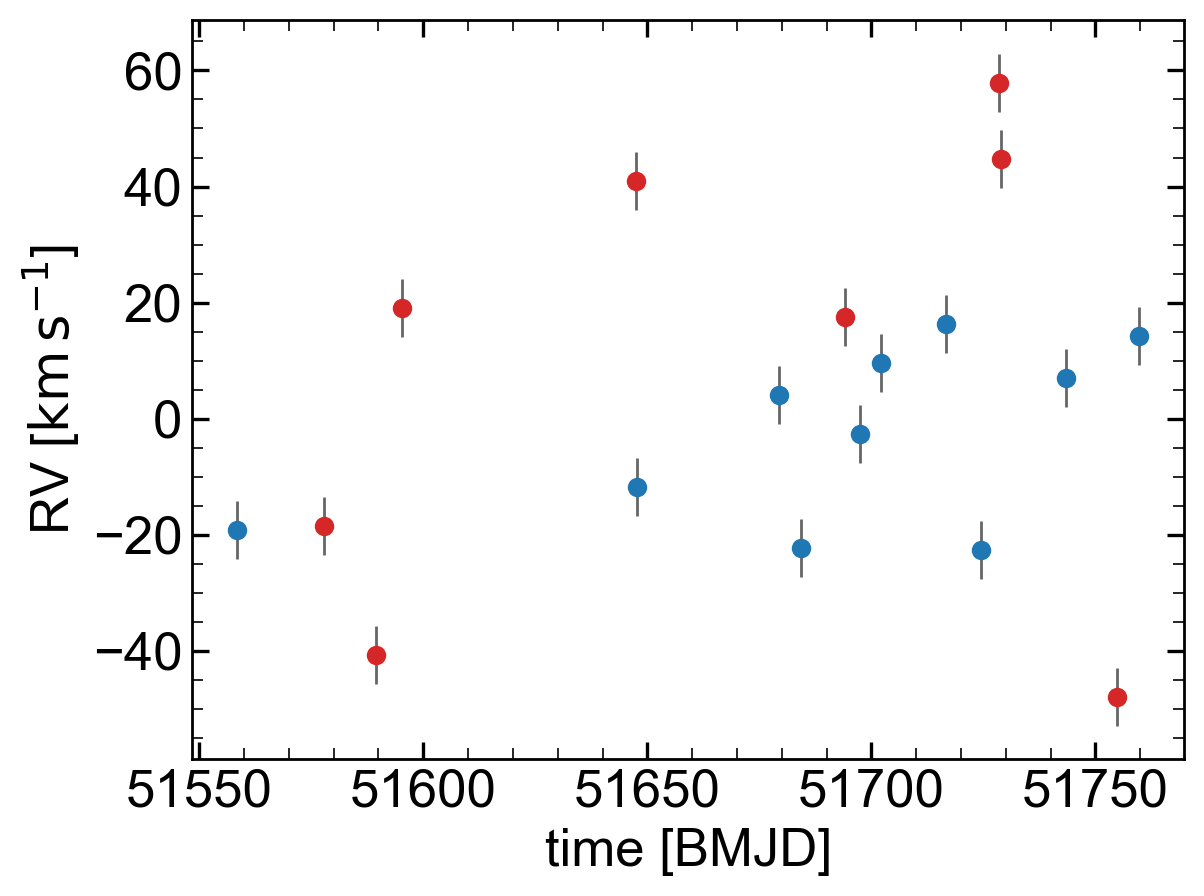

In [5]:
datas['1'].plot(color='tab:blue')  # primary
datas['2'].plot(color='tab:red')  # secondary

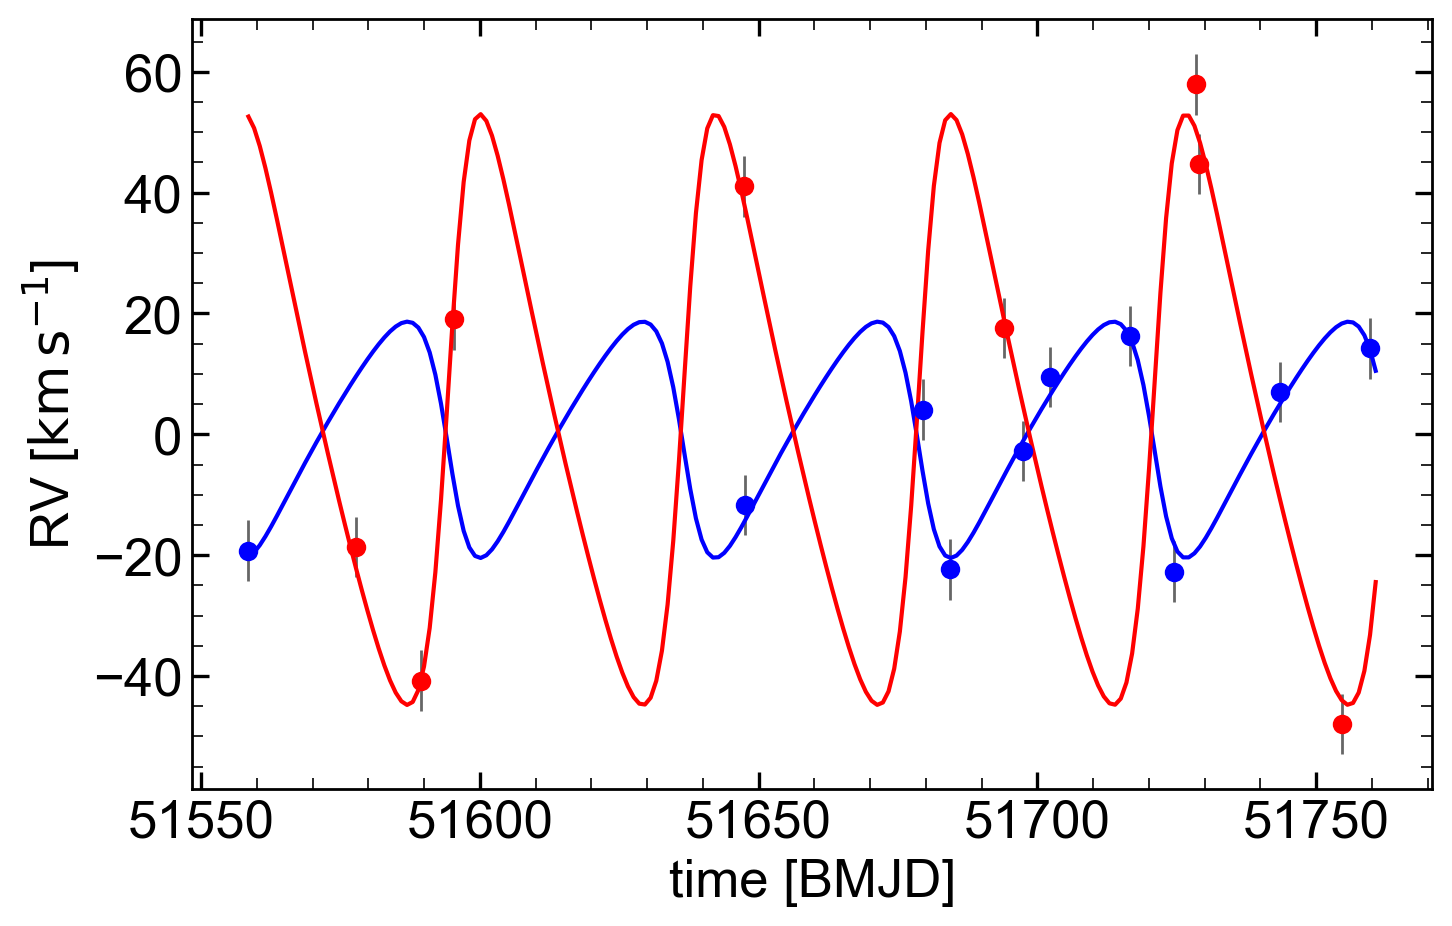

In [6]:
from thejoker._keplerian_orbit import KeplerianOrbit
#import torch
ecc = truth1['e']
omega = truth1['omega'].value
period = truth1['P'].value
#n = 2 * np.pi / period
#M0 = 0.5 * np.pi + np.zeros_like(n)
cos_omega = np.cos(omega)
sin_omega = np.sin(omega)
opsw = 1 + sin_omega
E0 = 2 * np.arctan2(
                np.sqrt(1 - ecc) * cos_omega,
                np.sqrt(1 + ecc) * opsw,
            )
M0 = E0 - ecc * np.sin(E0)

orbit = KeplerianOrbit(
            period=period,
            ecc=truth1['e'],
            omega=truth1['omega'].value,
            t_periastron=t0.value,
        )

t_min = np.min(np.hstack([datas['1'].t.value, datas['2'].t.value]))
t_max = np.max(np.hstack([datas['1'].t.value, datas['2'].t.value]))
tdens = np.linspace(t_min, t_max+1, 200)*u.day

rv1_dens = orbit.get_radial_velocity(tdens, K=truth1['K'].value)+truth1['v0']
rv2_dens = -orbit.get_radial_velocity(tdens, K=truth2['K'].value)+truth1['v0']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

datas['1'].plot(color='blue')  # primary
datas['2'].plot(color='red')  # secondary

plt.plot(tdens, rv1_dens.eval(), color='b')
plt.plot(tdens, rv2_dens.eval(), color='r')

In [7]:
import thejoker.units as xu
with pm.Model() as model:
    dv0_1 = xu.with_unit(pm.Normal("dv0_1", 0, 10), u.km / u.s)
    prior = tj.JokerSB2Prior.default(
        P_min=0.5*u.day, P_max=500*u.day,
        sigma_v=25*u.km/u.s,
        sigma_K0_1=30*u.km/u.s,
        sigma_K0_2=30*u.km/u.s,
        v0_offsets=[dv0_1],
    )

In [8]:
joker = tj.TheJokerSB2(prior)

In [9]:
prior_samples,_ = prior.sample(size=1_000_00)
#prior_samples,_ = prior.sample(size=1_000)

In [10]:
##joker_helper = joker._make_joker_helper(datas)  # also validates data
#from thejoker.likelihood_helpers import rejection_sample_inmem                                                                              
#from thejoker.multiproc_helpers import rejection_sample_helper
#from thejoker.data_helpers import validate_prepare_data
#from thejoker.thejoker_sb2 import validate_prepare_data_sb2
#
#all_data, ids, M = validate_prepare_data_sb2(          
#    data, joker.prior.poly_trend, t_ref=data['1'].t_ref)

#from thejoker.thejoker_sb2 import CJokerSB2Helper
#joker_helper = CJokerSB2Helper(all_data, joker.prior, M) 


#_unit = getattr(prior.model[name], xu.UNIT_ATTR_NAME)
#to_unit = joker_helper.internal_units[name]
#_unit, to_unit

In [11]:
samples = joker.rejection_sample(datas, prior_samples, max_posterior_samples=1000)
samples

<JokerSB2Samples [P, e, omega, M0, s, K1, K2, v0, dv0_1] (1 samples)>

In [12]:
samples._sb2

True

In [13]:
samples.wrap_K(Kname='K1')
samples.wrap_K(Kname='K2')

<JokerSB2Samples [P, e, omega, M0, s, K1, K2, v0, dv0_1] (1 samples)>

Text(0, 0.5, 'e')

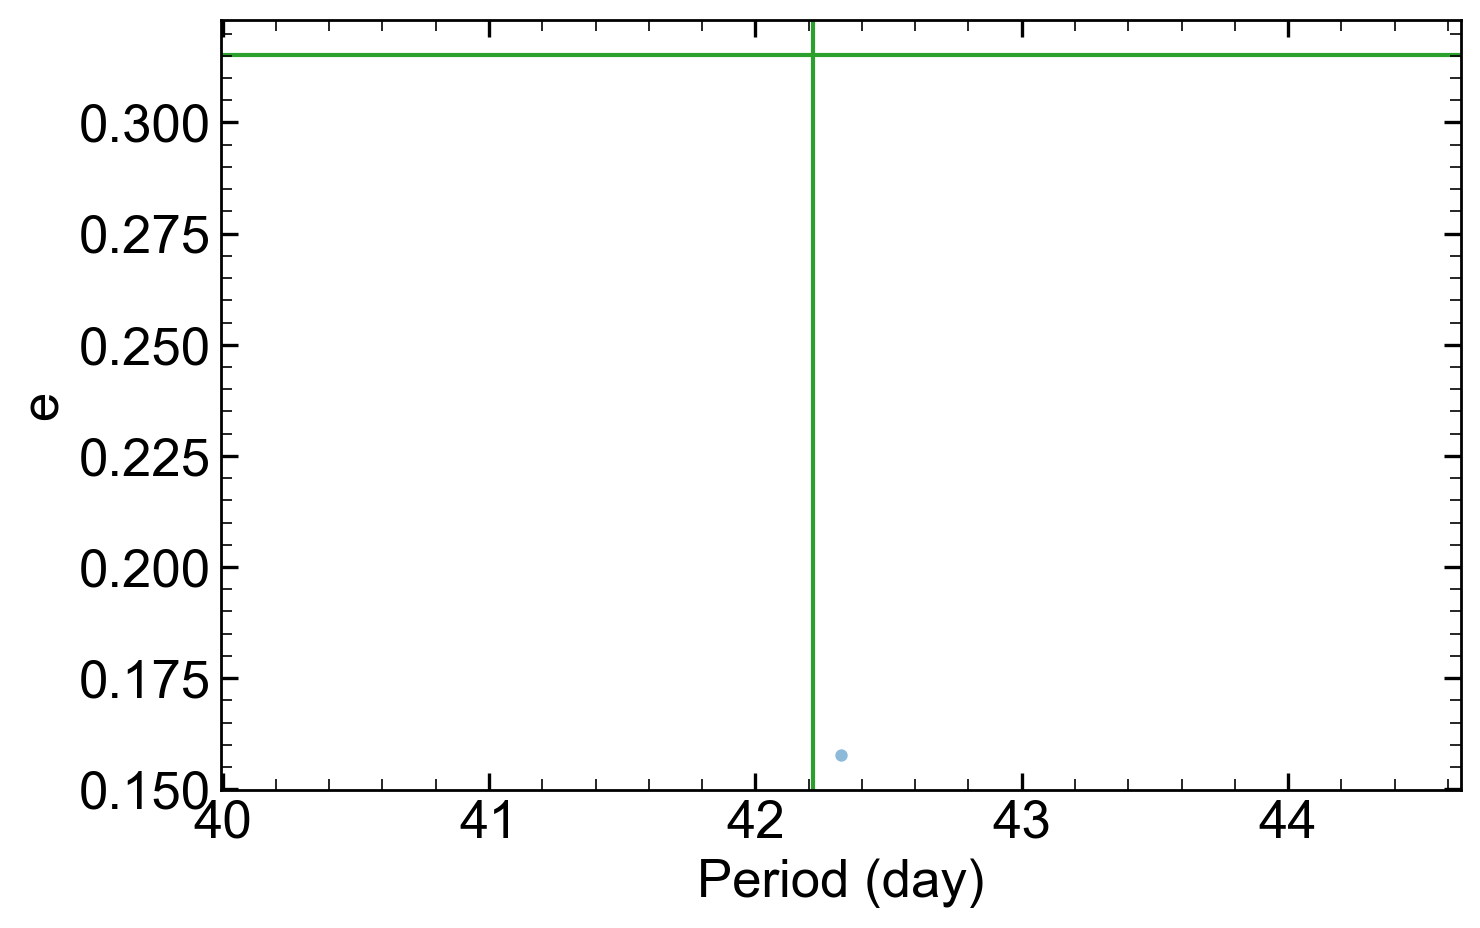

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.scatter(samples["P"], samples["e"], s=20, lw=0, alpha=0.5)

    ax.axvline(truth1["P"], zorder=-1, color="tab:green")
    ax.axhline(truth1["e"], zorder=-1, color="tab:green")
    #ax.text(
    #    truth1["P"], 0.95, "truth", fontsize=20, va="top", ha="left", color="tab:green"
    #)

plt.xlabel('Period (day)')
plt.ylabel('e')

Text(0.5, 0, 'Period (day)')

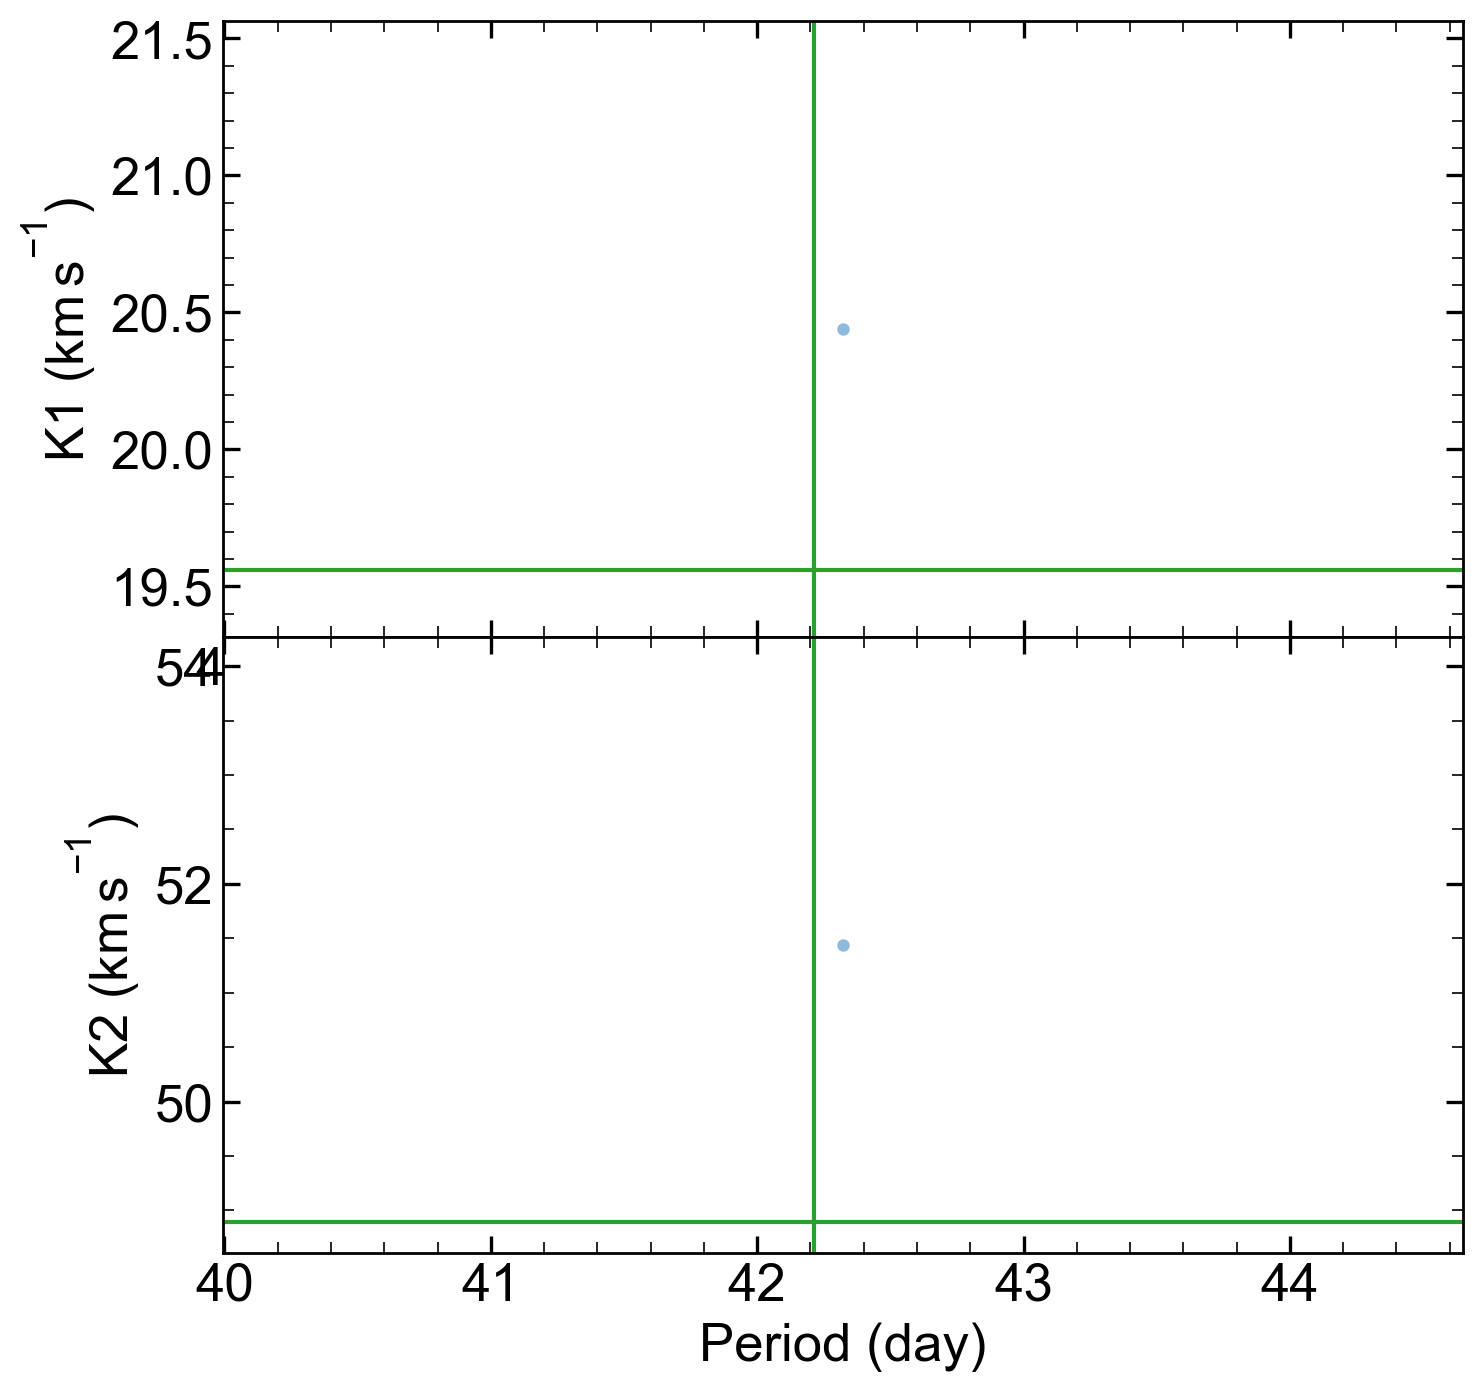

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plt.subplots_adjust(hspace=0)

ax = axs[0]
plt.sca(ax)
with quantity_support():
    ax.scatter(samples["P"], samples["K1"], s=20, lw=0, alpha=0.5)

    ax.axvline(truth1["P"], zorder=-1, color="tab:green")
    ax.axhline(truth1["K"], zorder=-1, color="tab:green")
    #ax.text(
    #    truth1["P"], 0.95, "truth", fontsize=20, va="top", ha="left", color="tab:green"
    #)


plt.ylabel(r'K1 ($km\, s^{-1}$)')

ax = axs[1]
plt.sca(ax)
with quantity_support():
    ax.scatter(samples["P"], samples["K2"], s=20, lw=0, alpha=0.5)

    ax.axvline(truth1["P"], zorder=-1, color="tab:green")
    ax.axhline(truth2["K"], zorder=-1, color="tab:green")
    #ax.text(
    #    truth2["P"], 0.95, "truth", fontsize=20, va="top", ha="left", color="tab:green"
    #)

plt.ylabel(r'K2 ($km\, s^{-1}$)')
plt.xlabel('Period (day)')

In [16]:
np.median(samples['P'])

<Quantity 42.3212274 d>

(-75.0, 75.0)

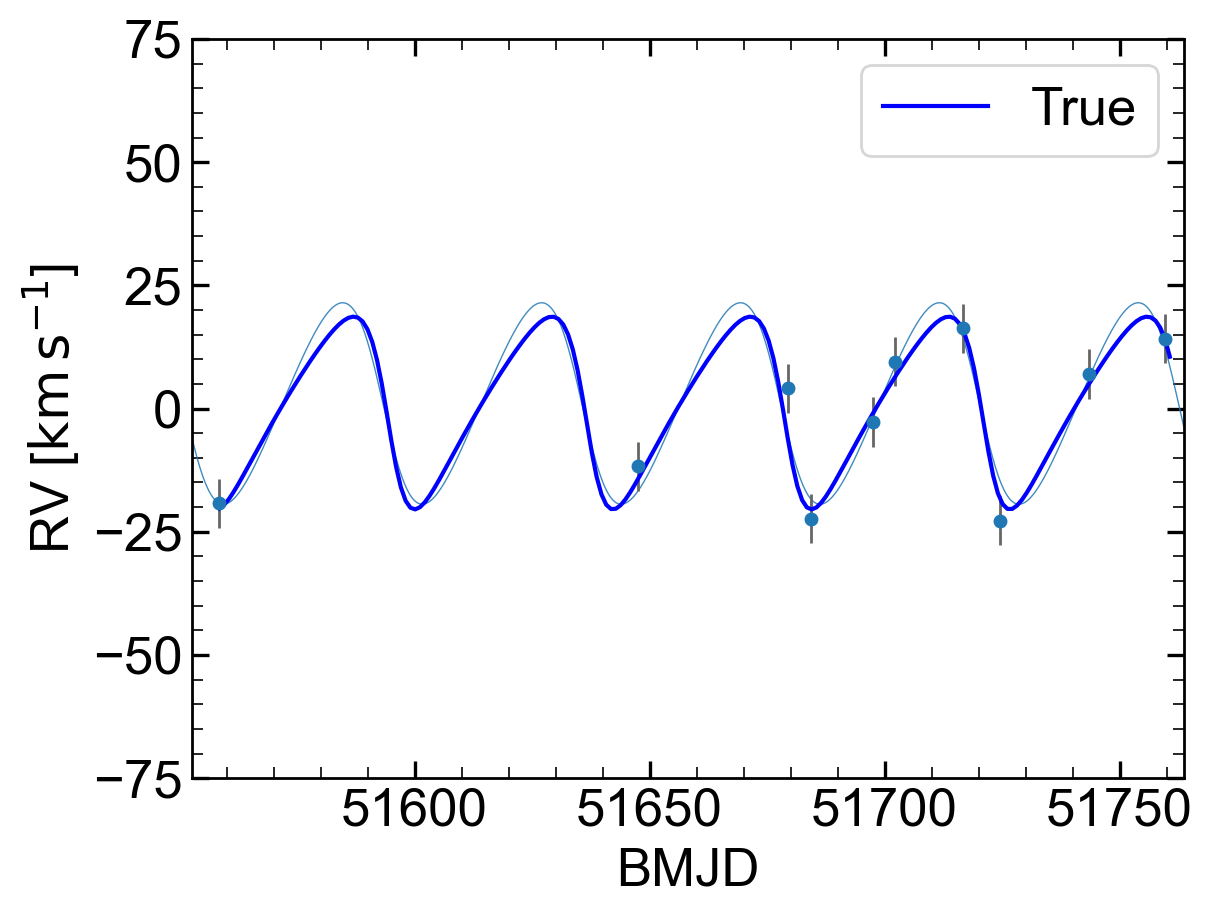

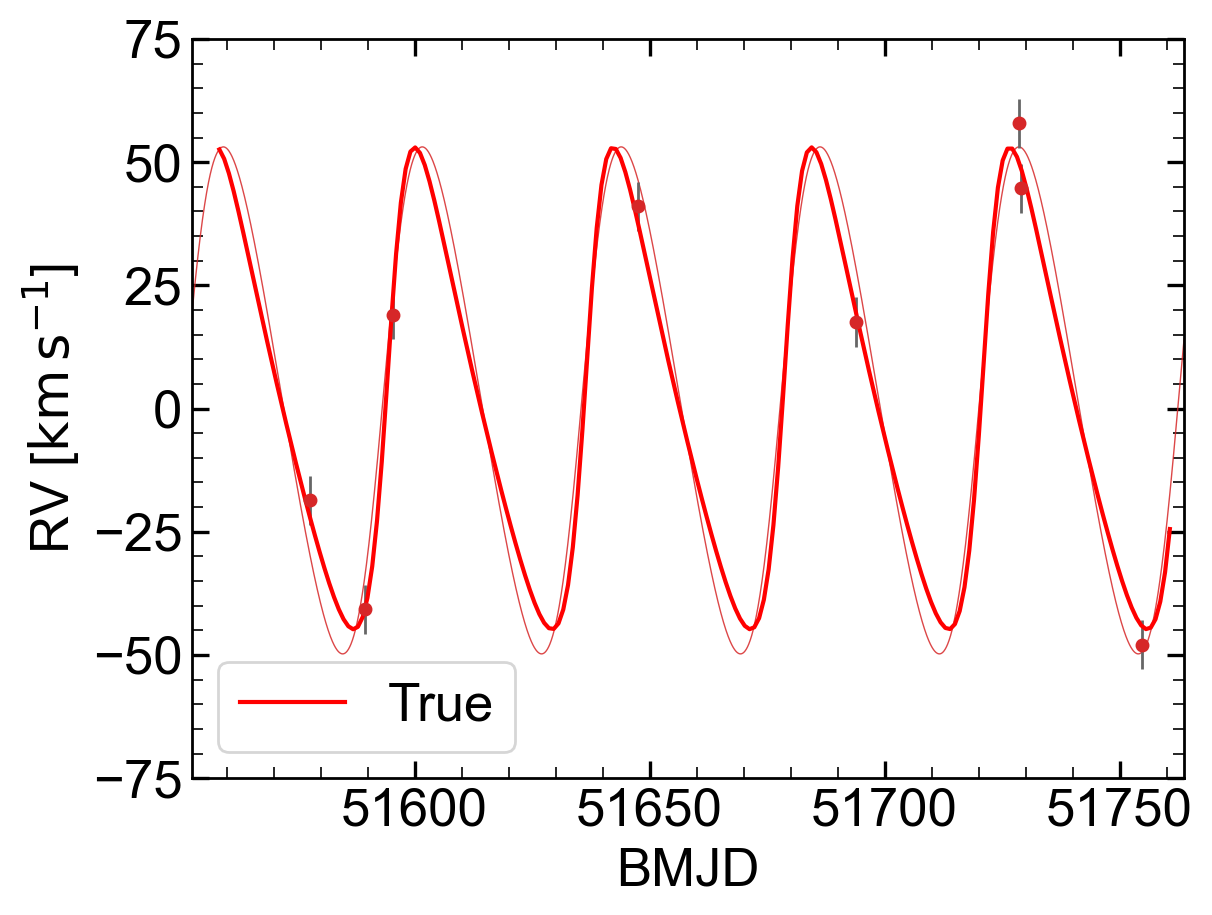

In [17]:
tgrid = np.linspace(t0.mjd, t0.mjd + 5*truth1['P'].value, 4096)

fig, ax = plt.subplots()
_ = tj.plot_rv_curves(data=datas['1'], samples=samples.primary,
                      data_plot_kwargs=dict(color='tab:blue'),
                      plot_kwargs=dict(color='tab:blue'),
                      t_grid=tgrid, ax=ax)
ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-75, 75)
ax.plot(tdens, rv1_dens.eval(), color='b', label='True')
plt.legend()



fig, ax = plt.subplots()
_ = tj.plot_rv_curves(data=datas['2'], samples=samples.secondary, 
                      data_plot_kwargs=dict(color='tab:red'),
                      plot_kwargs=dict(color='tab:red'),
                      t_grid=tgrid, ax=ax)


ax.plot(tdens, rv2_dens.eval(), color='r', label='True')
plt.legend()
ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-75, 75)

In [18]:
with prior.model:
    mcmc_init = joker.setup_mcmc(datas, samples)

    trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)

idx_star2:  [False False False False False False False False False False  True  True
  True  True  True  True  True  True]


/var/folders/pj/yn67ml9d7dgd1v5smh0xzb1w0000gn/T/ipykernel_13065/112416945.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [dv0_1, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K1, K2, v0]


Output()

Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
KeplerianOrbit?

Init signature:
KeplerianOrbit(
    period=None,
    a=None,
    t0=None,
    t_periastron=None,
    incl=None,
    b=None,
    duration=None,
    ecc=None,
    omega=None,
    sin_omega=None,
    cos_omega=None,
    Omega=None,
    m_planet=0.0,
    m_star=None,
    r_star=None,
    rho_star=None,
    ror=None,
    model=None,
    **kwargs,
)
Docstring:     
A system of bodies on Keplerian orbits around a common central

Given the input parameters, the values of all other parameters will be
computed so a ``KeplerianOrbit`` instance will always have attributes for
each argument. Note that the units of the computed attributes will all be
in the standard units of this class (``R_sun``, ``M_sun``, and ``days``)
except for ``rho_star`` which will be in ``g / cm^3``.

There are only specific combinations of input parameters that can be used:

1. First, either ``period`` or ``a`` must be given. If values are given
   for both parameters, then neither ``m_star`` or ``rho_star`` can be
   defi

/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K1'}>],
       [<Axes: title={'center': 'K2'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'M0'}>, <Axes: title={'center': 'M0'}>],
       [<Axes: title={'center': 'P'}>, <Axes: title={'center': 'P'}>],
       [<Axes: title={'center': '__M0_angle1'}>,
        <Axes: title={'center': '__M0_angle1'}>],
       [<Axes: title={'center': '__M0_angle2'}>,
        <Axes: title={'center': '__M0_angle2'}>],
       [<Axes: title={'center': '__omega_angle1'}>,
        <Axes: title={'center': '__omega_angle1'}>],
       [<Axes: title={'center': '__omega_angle2'}>,
        <Axes: title={'center': '__omega_angle2'}>],
       [<Axes: title={'center': 'dv0_1'}>,
        <Axes: title={'center': 'dv0_1'}>],
       [<Axes: title={'center': 'e'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'ln_likelihood'}>,
        <Axes: title={'center': 'ln_likelihood'}>],
       [<Axes: title={'center': 'ln_prior

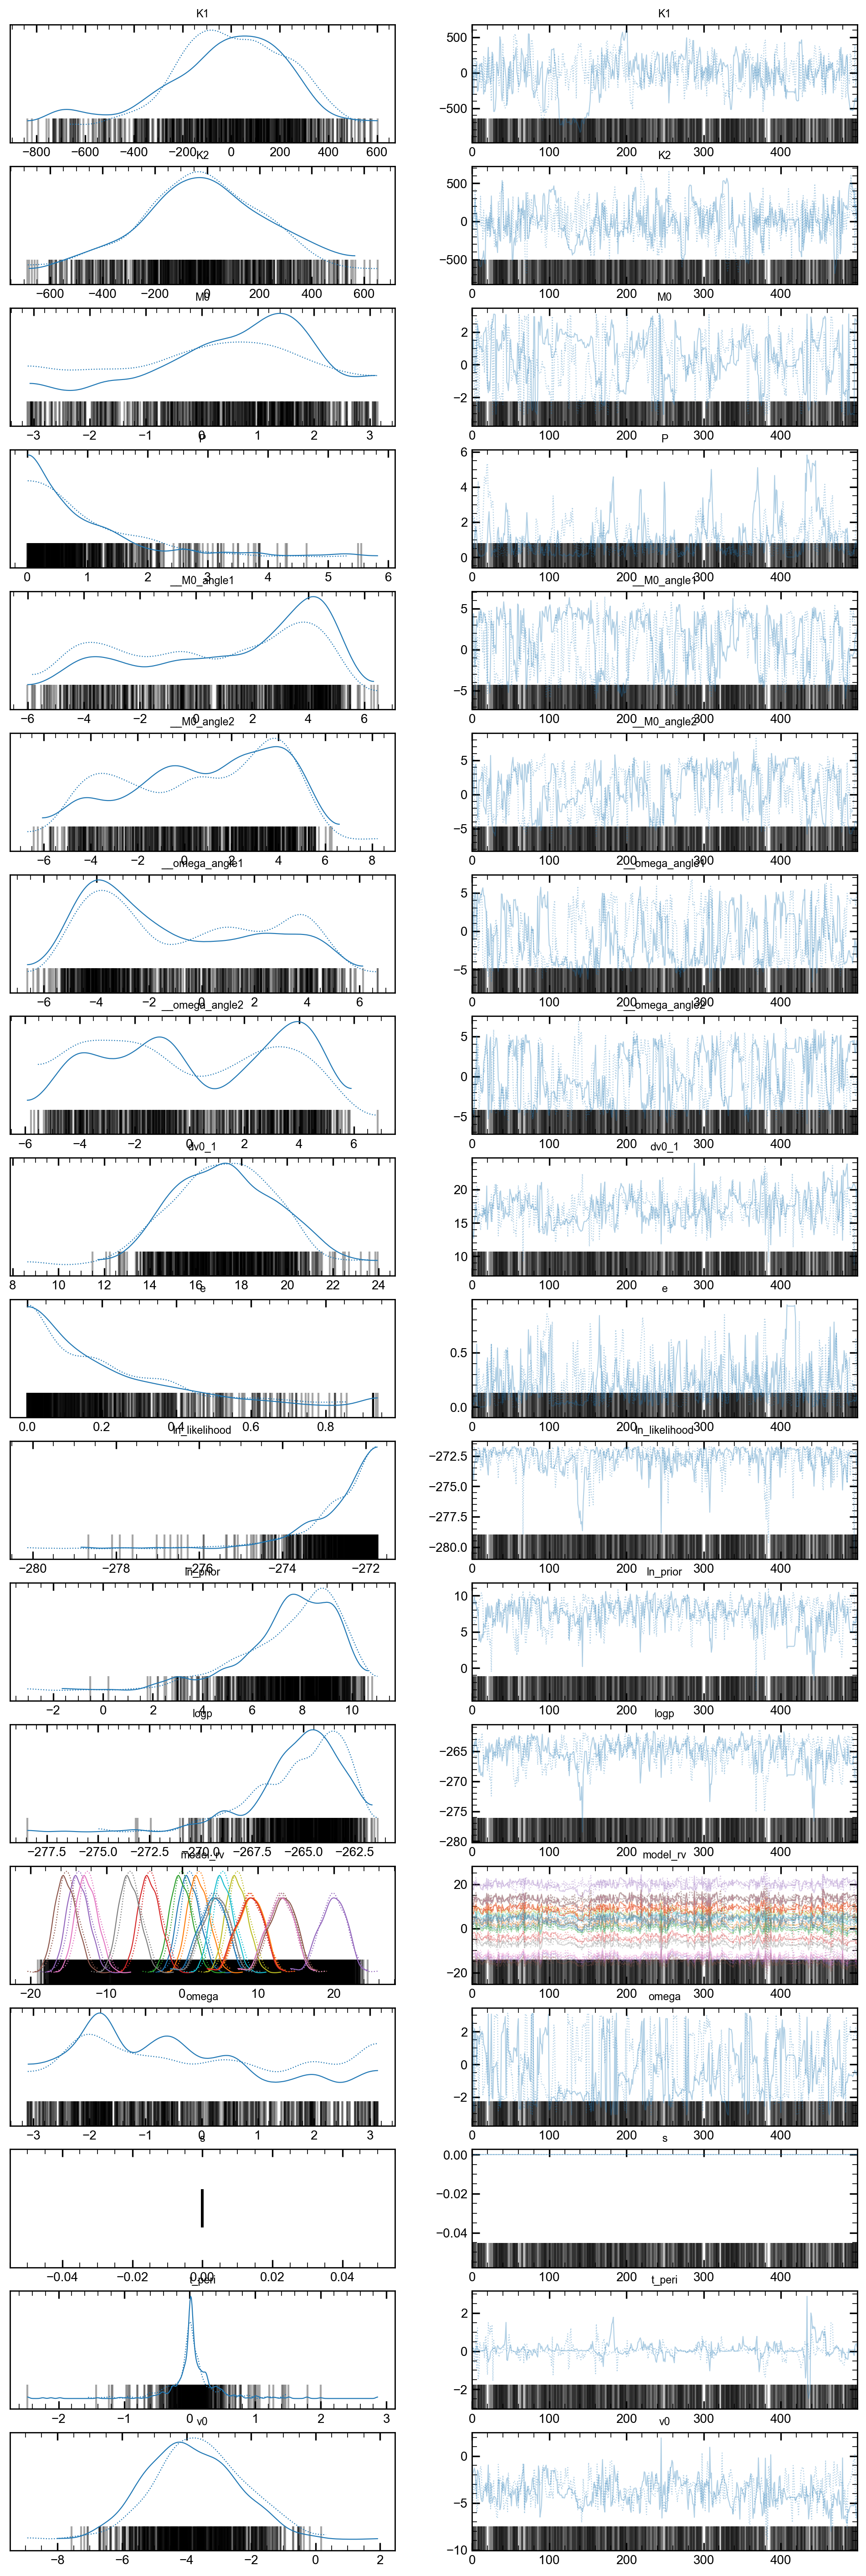

In [185]:
import arviz as az
#data = az.load_arviz_data('non_centered_eight')
#>>> coords = {'school': ['Choate', 'Lawrenceville']}
az.plot_trace(trace)

In [19]:
mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, datas)
mcmc_samples = mcmc_samples.wrap_K(Kname='K1')
mcmc_samples = mcmc_samples.wrap_K(Kname='K2')

In [20]:
import pytensor.tensor as tt

tt.h

AttributeError: module 'pytensor.tensor' has no attribute 'h'

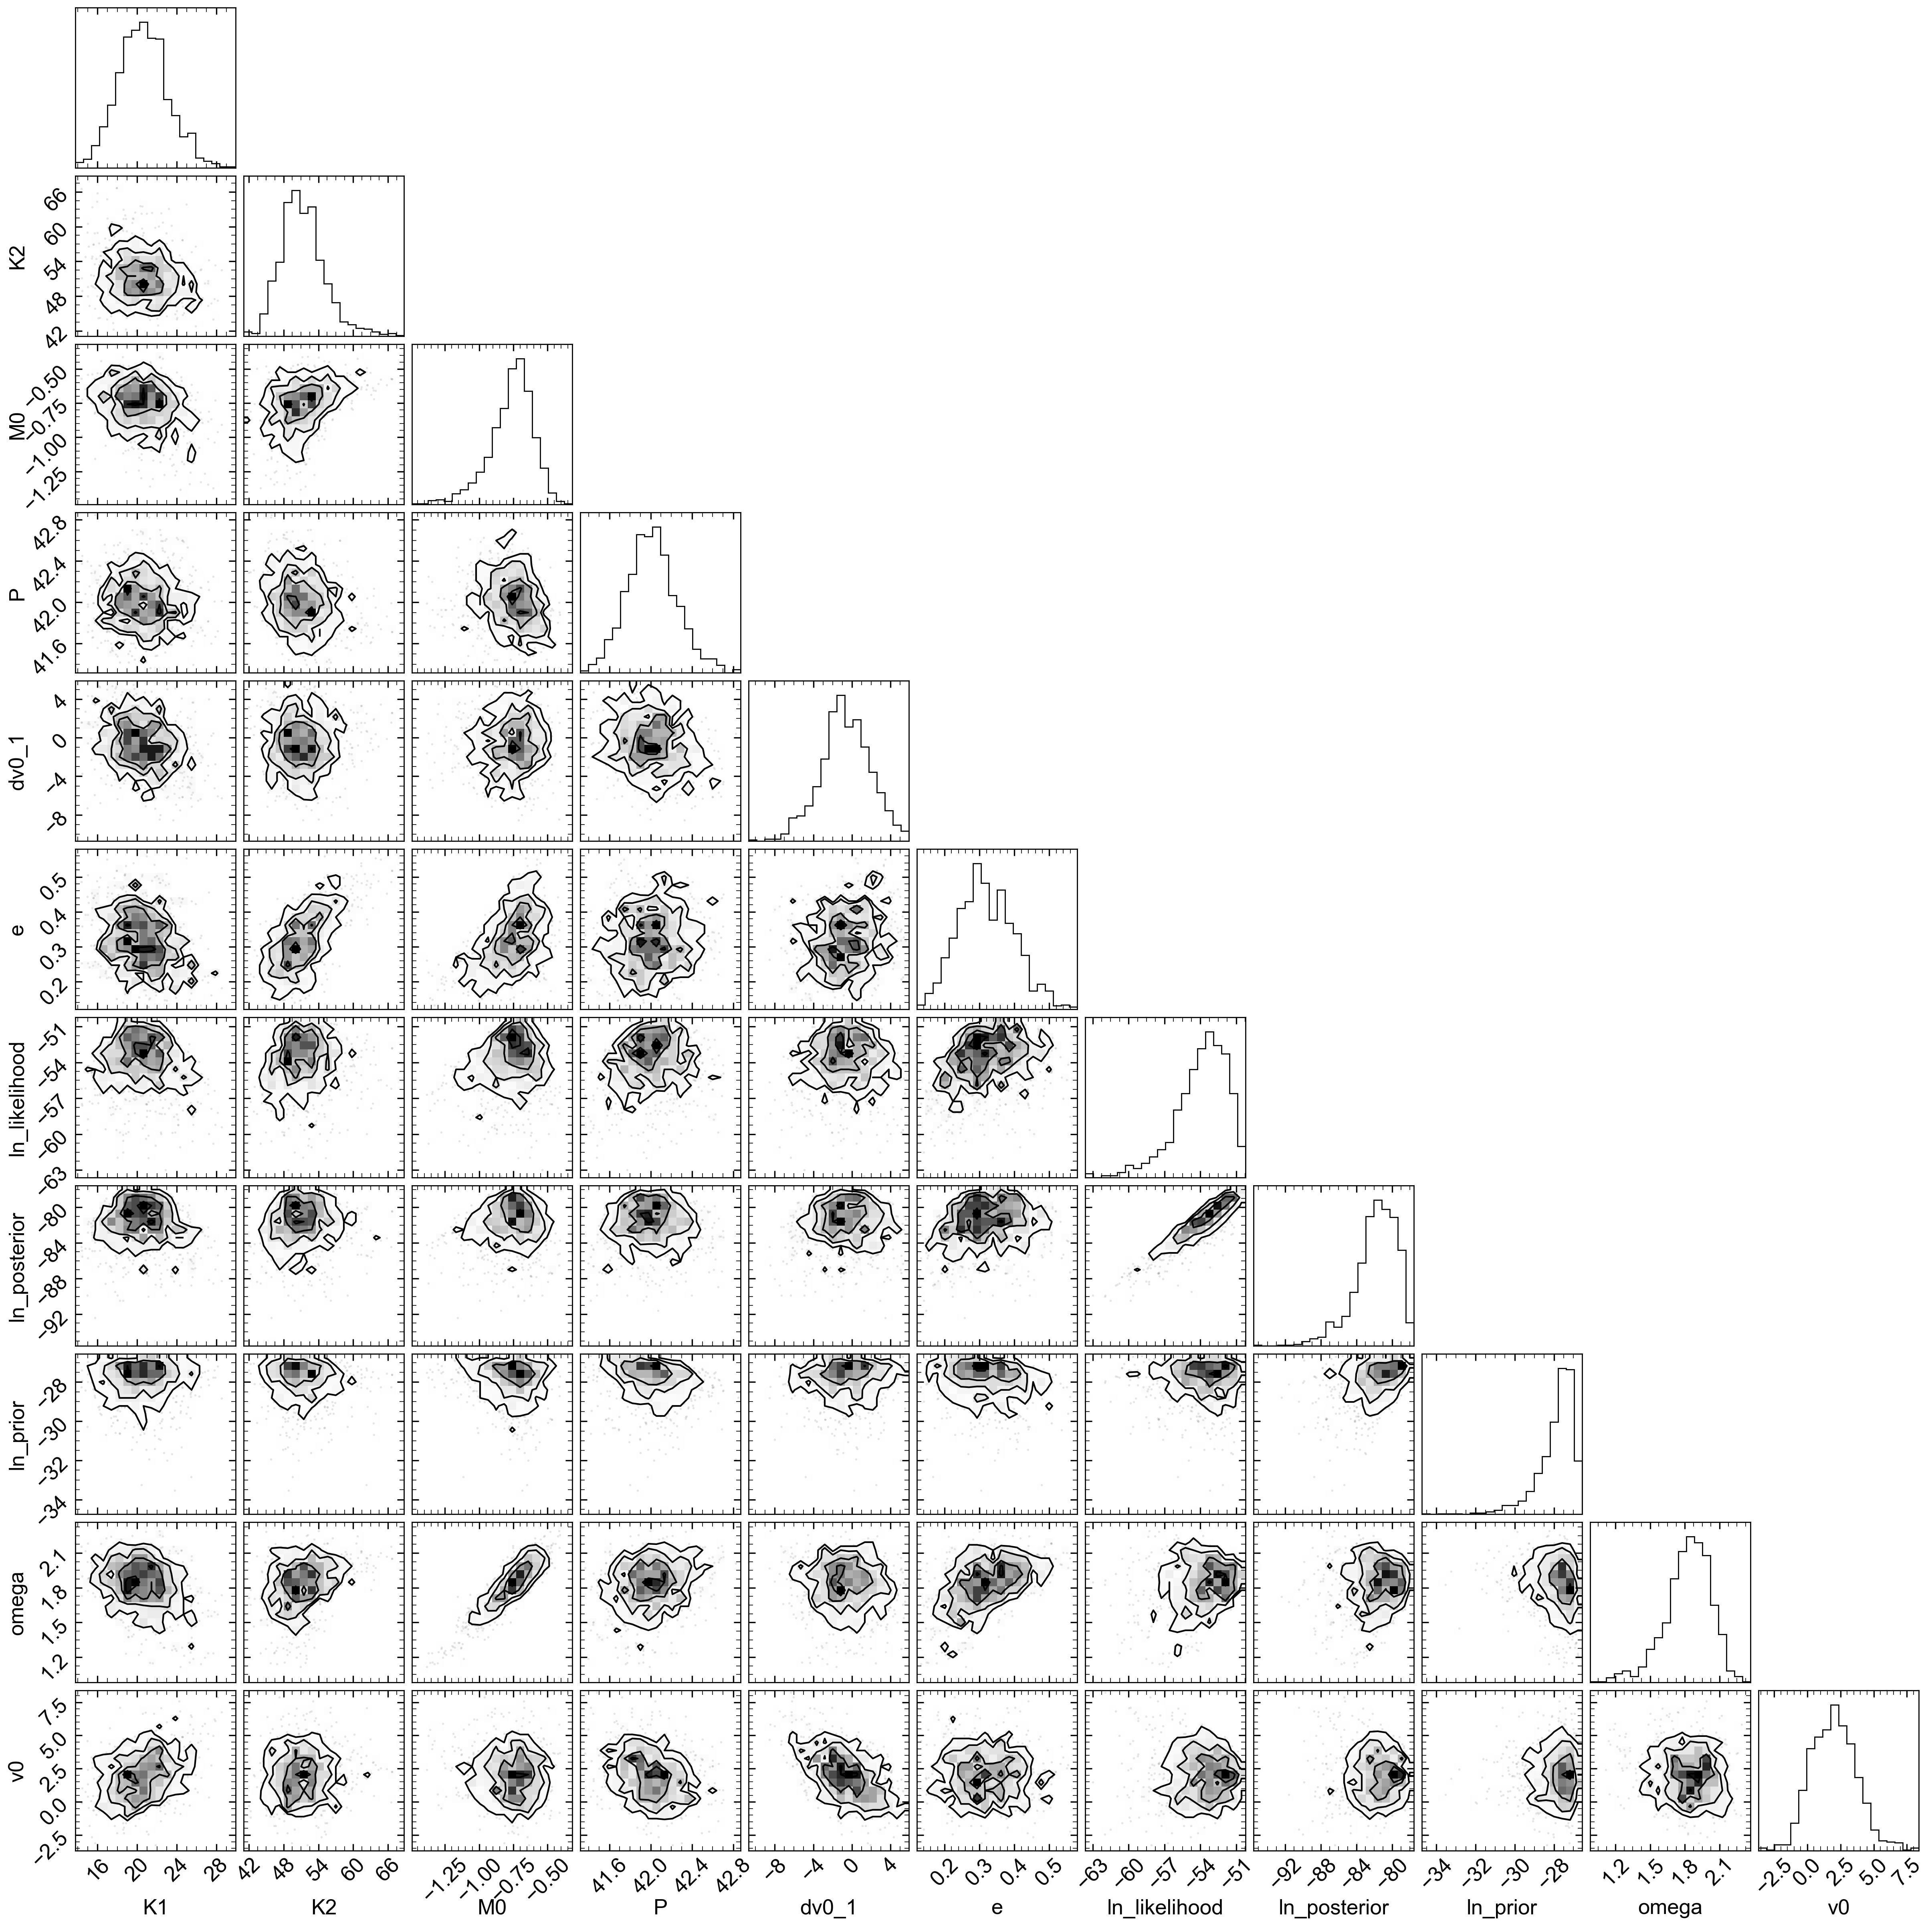

In [21]:
import corner
df = mcmc_samples.tbl.to_pandas()
colnames = mcmc_samples.par_names
colnames.pop(colnames.index("s"))
truth_ = [truth1['K'], truth2['K']]
_ = corner.corner(df[colnames])

In [37]:
data = datas.copy()
joker_samples = samples.copy()

import pymc as pm
import pytensor.tensor as pt
from thejoker.prior import _validate_model
import thejoker.units as xu
from thejoker._keplerian_orbit import KeplerianOrbit
from thejoker.samples import JokerSamples
from thejoker.samples_analysis import is_P_unimodal
from thejoker.logging import logger
from thejoker.likelihood_helpers import get_trend_design_matrix
from thejoker.prior_helpers import validate_n_offsets, validate_poly_trend
from thejoker.thejoker_sb2 import validate_prepare_data_sb2
custom_func=None

model = _validate_model(model)

# Reduce data, strip units:
data, ids, _ = validate_prepare_data_sb2(
    data, joker.prior.poly_trend)

samples.ln_unmarginalized_likelihood(data)

KeyError: 'K'

In [42]:
np.median(samples.tbl['K2'])

<Quantity 35.0332756 km / s>

In [29]:
datas['1']._t_bmjd

array([51558.46557387, 51647.61660082, 51679.46992058, 51684.32378554,
       51697.50096613, 51702.22974618, 51716.61022834, 51724.4606873 ,
       51743.52032301, 51759.70365329])

In [25]:
data = datas.copy()
joker_samples = samples.copy()

import pymc as pm
import pytensor.tensor as pt
from thejoker.prior import _validate_model
import thejoker.units as xu
from thejoker._keplerian_orbit import KeplerianOrbit
from thejoker.samples import JokerSamples
from thejoker.samples_analysis import is_P_unimodal
from thejoker.logging import logger
from thejoker.likelihood_helpers import get_trend_design_matrix
from thejoker.prior_helpers import validate_n_offsets, validate_poly_trend
from thejoker.thejoker_sb2 import validate_prepare_data_sb2
custom_func=None

model = _validate_model(model)

# Reduce data, strip units:
data, ids, _ = validate_prepare_data_sb2(
    data, joker.prior.poly_trend
)
x = data._t_bmjd - data._t_ref_bmjd
y = data.rv.value
err = data.rv_err.to_value(data.rv.unit)


# First, prepare the joker_samples:
if not isinstance(joker_samples, JokerSamples):
    raise TypeError(
        "You must pass in a JokerSamples instance to the "
        "joker_samples argument."
    )
if len(joker_samples) > 1:
    # check if unimodal in P, if not, warn
    if not is_P_unimodal(joker_samples, data):
        logger.warn("TODO: samples ain't unimodal")
    MAP_sample = joker_samples.median_period()
else:
    MAP_sample = joker_samples
    

mcmc_init = {}
for name in joker.prior.par_names:
    unit = getattr(joker.prior.pars[name], xu.UNIT_ATTR_NAME)
    mcmc_init[name] = MAP_sample[name].to_value(unit)
if custom_func is not None:
    mcmc_init = custom_func(mcmc_init, MAP_sample, model)
mcmc_init = {k: np.squeeze(v) for k, v in mcmc_init.items()}



p = joker.prior.pars

if "t_peri" not in model.named_vars:
     with model:
         pm.Deterministic("t_peri", p["P"] * p["M0"] / (2 * np.pi))


with model:
# Set up the orbit model
        orbit = KeplerianOrbit(
            period=p["P"],
            ecc=p["e"],
            omega=p["omega"],
            t_periastron=model.named_vars["t_peri"],
        )

# design matrix
M = get_trend_design_matrix(data, ids, joker.prior.poly_trend)
idx_star2 = np.array(ids) == 2

# deal with v0_offsets, trend here:
_, offset_names = validate_n_offsets(joker.prior.n_offsets)
_, vtrend_names = validate_poly_trend(joker.prior.poly_trend)

with model:
    v_pars = (
        [p["v0"]]
        + [p[name] for name in offset_names]
        + [p[name] for name in vtrend_names[1:]]
    )  # skip v0
    v_trend_vec = pt.stack(v_pars, axis=0)
    trend = pt.dot(M, v_trend_vec)
    
    rv_model1 = orbit.get_radial_velocity(x, K=p["K1"])
    rv_model2 = orbit.get_radial_velocity(x, K=p["K2"])
    rv_value = np.hstack([rv_model1.eval()[~idx_star2], rv_model2.eval()[idx_star2]])
    rv_model = rv_model1.fill(rv_value) + trend
    pm.Deterministic("model_rv", rv_model)

    err = pt.sqrt(err**2 + p["s"] ** 2)
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y)

    pm.Deterministic("logp", model.logp())

    dist = pm.Normal.dist(model.model_rv, data.rv_err.value)
    lnlike = pm.Deterministic(
              "ln_likelihood", pm.logp(dist, data.rv.value).sum(axis=-1)
            )

    pm.Deterministic("ln_prior", model.logp() - lnlike)


ValueError: Variable name model_rv already exists.

In [39]:
data = datas.copy()
joker_samples = samples.copy()

import pymc as pm
import pytensor.tensor as pt
from thejoker.prior import _validate_model
import thejoker.units as xu
from thejoker._keplerian_orbit import KeplerianOrbit
from thejoker.samples import JokerSamples
from thejoker.samples_analysis import is_P_unimodal
from thejoker.logging import logger
from thejoker.likelihood_helpers import get_trend_design_matrix
from thejoker.prior_helpers import validate_n_offsets, validate_poly_trend
from thejoker.thejoker_sb2 import validate_prepare_data_sb2
custom_func=None

model = _validate_model(model)

# Reduce data, strip units:
data, ids, _ = validate_prepare_data_sb2(
    data, joker.prior.poly_trend
)
x = data._t_bmjd - data._t_ref_bmjd
y = data.rv.value
err = data.rv_err.to_value(data.rv.unit)
x1 = datas["1"]._t_bmjd - data._t_ref_bmjd
y1 = datas["1"].rv.value
err1 = datas["1"].rv_err.to_value(data.rv.unit)
x2 = datas["2"]._t_bmjd - data._t_ref_bmjd
y2 = datas["2"].rv.value
err2 = datas["2"].rv_err.to_value(data.rv.unit)


# First, prepare the joker_samples:
if not isinstance(joker_samples, JokerSamples):
    raise TypeError(
        "You must pass in a JokerSamples instance to the "
        "joker_samples argument."
    )
if len(joker_samples) > 1:
    # check if unimodal in P, if not, warn
    if not is_P_unimodal(joker_samples, data):
        logger.warn("TODO: samples ain't unimodal")
    MAP_sample = joker_samples.median_period()
else:
    MAP_sample = joker_samples
    

mcmc_init = {}
for name in joker.prior.par_names:
    unit = getattr(joker.prior.pars[name], xu.UNIT_ATTR_NAME)
    mcmc_init[name] = MAP_sample[name].to_value(unit)
if custom_func is not None:
    mcmc_init = custom_func(mcmc_init, MAP_sample, model)
mcmc_init = {k: np.squeeze(v) for k, v in mcmc_init.items()}



p = joker.prior.pars

if "t_peri" not in model.named_vars:
     with model:
         pm.Deterministic("t_peri", p["P"] * p["M0"] / (2 * np.pi))


with model:
# Set up the orbit model
        orbit = KeplerianOrbit(
            period=p["P"],
            ecc=p["e"],
            omega=p["omega"],
            t_periastron=model.named_vars["t_peri"],
        )

# design matrix
M = get_trend_design_matrix(data, ids, joker.prior.poly_trend)
idx_star2 = np.array(ids) == "2"
# deal with v0_offsets, trend here:
_, offset_names = validate_n_offsets(joker.prior.n_offsets)
_, vtrend_names = validate_poly_trend(joker.prior.poly_trend)

with model:
    v_pars = (
        [p["v0"]]
        + [p[name] for name in offset_names]
        + [p[name] for name in vtrend_names[1:]]
    )  # skip v0
    v_trend_vec = pt.stack(v_pars, axis=0)
    trend = pt.dot(M, v_trend_vec)
    
    rv_model1 = orbit.get_radial_velocity(x1, K=p["K1"])+ trend[~idx_star2]
    rv_model2 = orbit.get_radial_velocity(x2, K=p["K2"])+ trend[idx_star2]
    #rv_value = np.hstack([rv_model1.eval()[~idx_star2], rv_model2.eval()[idx_star2]])
    #rv_model = rv_model1.fill(rv_value) + trend
    #pm.Deterministic("model_rv1", rv_model1)
    #pm.Deterministic("model_rv2", rv_model2)

    err = pt.sqrt(err**2 + p["s"] ** 2)
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y)

    pm.Deterministic("logp", model.logp())

    dist = pm.Normal.dist(model.model_rv, data.rv_err.value)
    lnlike = pm.Deterministic(
              "ln_likelihood", pm.logp(dist, data.rv.value).sum(axis=-1)
            )

    pm.Deterministic("ln_prior", model.logp() - lnlike)


ValueError: Variable name obs already exists.

In [34]:
trend[1:10]

Subtensor{start:stop}.0

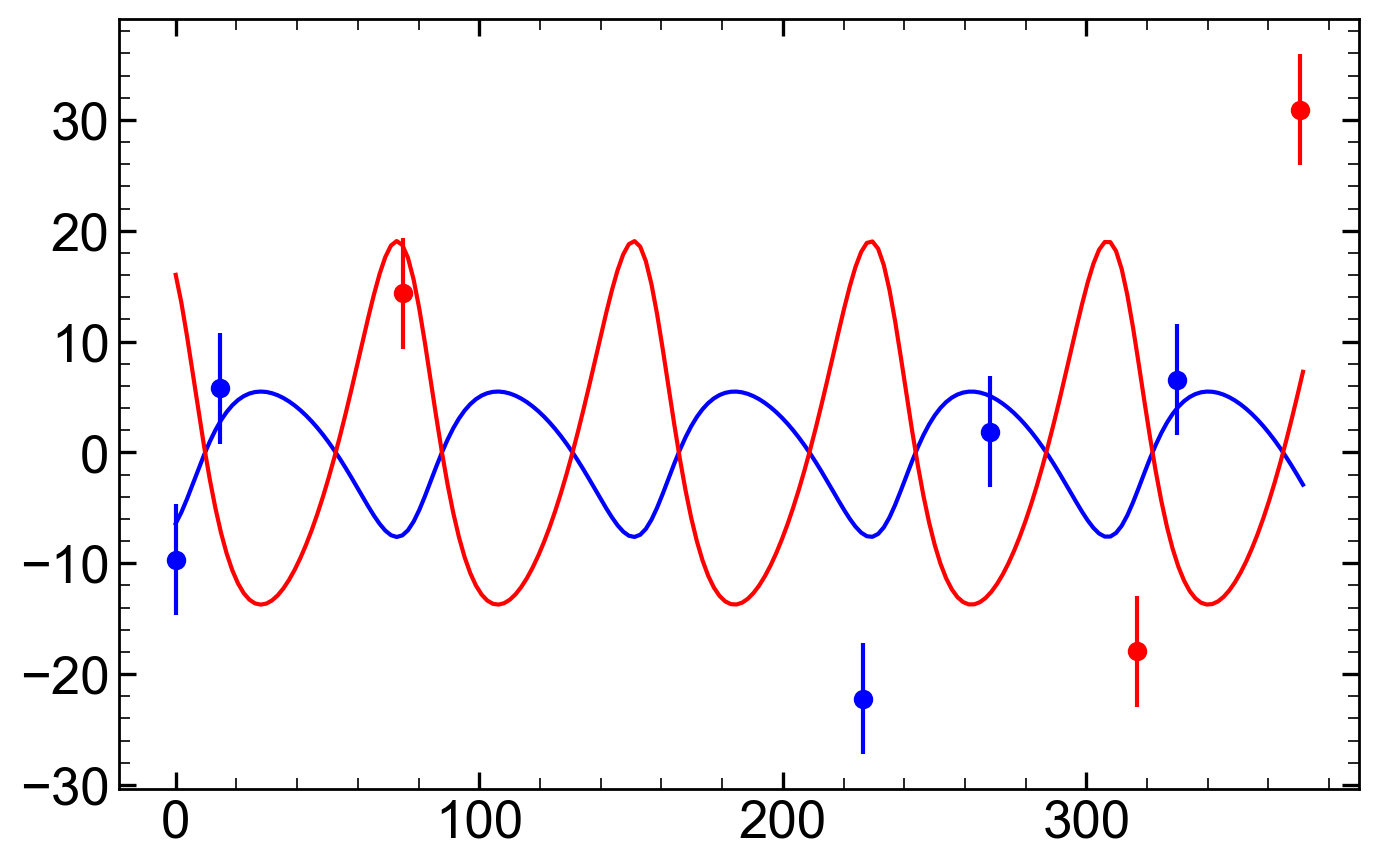

In [117]:
from thejoker._keplerian_orbit import KeplerianOrbit
#import torch
ecc = 0.4
omega = np.pi*0.7

orbit = KeplerianOrbit(
            period=truth1['P'].value,
            ecc=truth1['e'],
            omega=truth1['omega'].value,
            t_periastron=0,
        )
tdens = np.linspace(0, np.max(x)+1, 200)*u.day

rv1_dens = orbit.get_radial_velocity(tdens, K=truth1['K'].value)
rv2_dens = -orbit.get_radial_velocity(tdens, K=truth2['K'].value)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.errorbar(x[idx_star2], y[idx_star2], yerr=err.eval()[idx_star2], fmt='o', color='r', label='RV2')
    ax.errorbar(x[~idx_star2], y[~idx_star2], yerr=err.eval()[~idx_star2], fmt='o', color='b', label='RV1')

plt.plot(tdens, rv1_dens.eval(), color='b')
plt.plot(tdens, rv2_dens.eval(), color='r')

# test the class KeplerianOrbit of from _keplerian_orbit

Text(0, 0.5, 'RV ($km\\, s^{-1}$)')

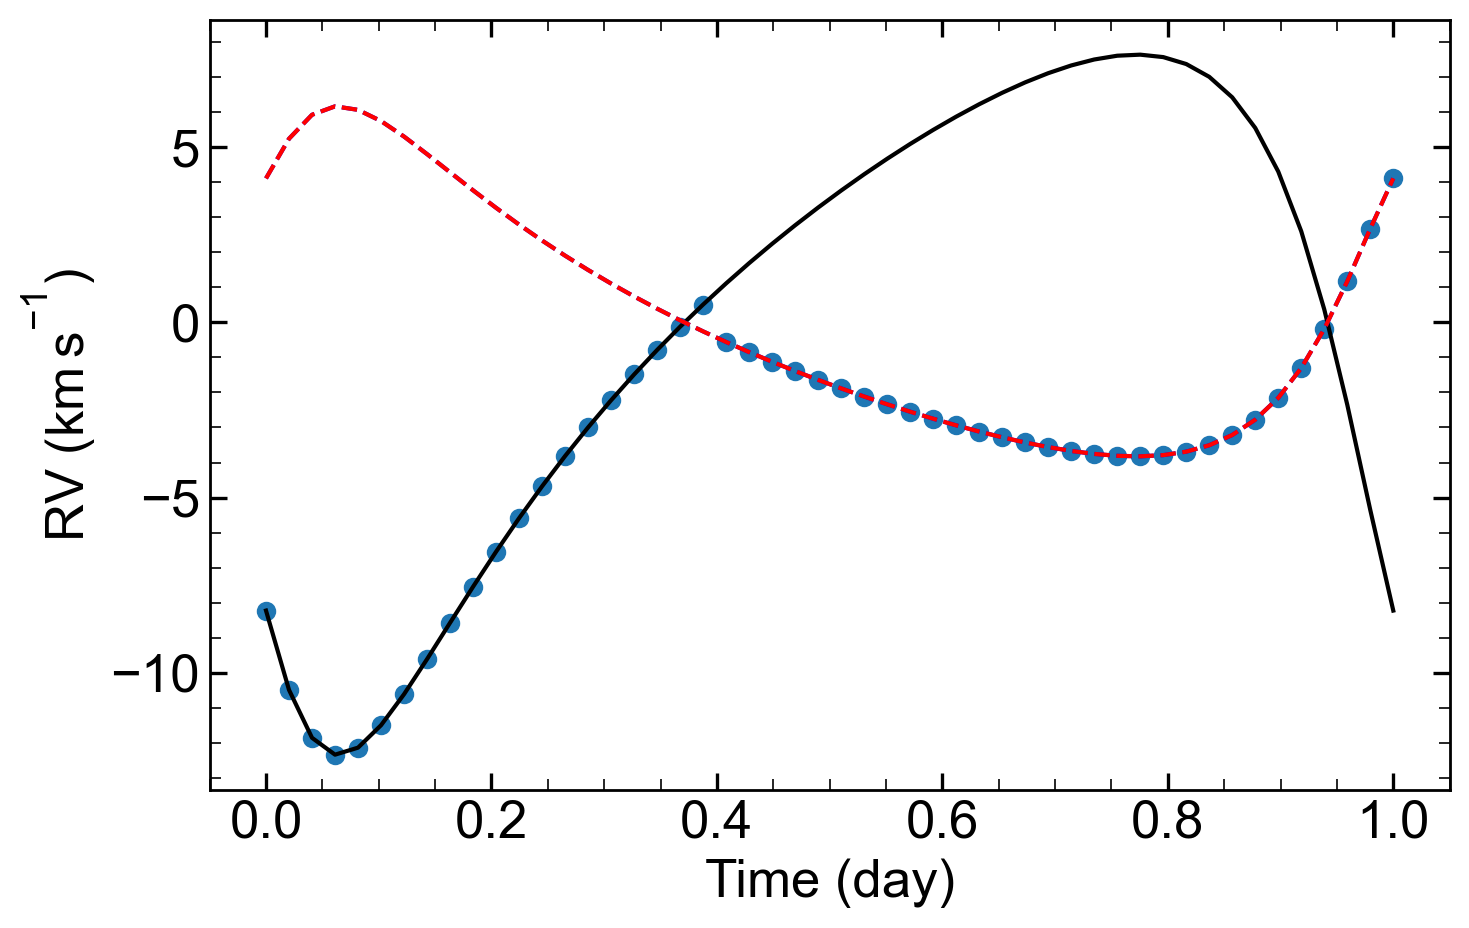

In [107]:
from thejoker._keplerian_orbit import KeplerianOrbit
#import torch
ecc = 0.4
omega = np.pi*0.7

orbit1 = KeplerianOrbit(
            period=1,
            ecc=ecc,
            omega=omega,
            t_periastron=0,
        )


orbit2 = KeplerianOrbit(
            period=1,
            ecc=ecc,
            omega=omega+np.pi,
            t_periastron=0,
        )


tt = np.linspace(0, 1, 50)*u.day
rv1 = orbit1.get_radial_velocity(tt, K=10)
rv2 = orbit2.get_radial_velocity(tt, K=5)

rv1_ = orbit1.get_radial_velocity(tt[:20], K=10)
rv2_ = orbit2.get_radial_velocity(tt[20:], K=5)

delta_rv = rv1+rv2

#rv = rv1.copy()
rv_value = np.hstack([rv1_.eval(),rv2_.eval()])
#rv[:4] = rv1[:4]
#rv[4:] = rv2[4:]
rv = rv1.fill(rv_value)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.plot(tt, rv1.eval(), color='k', ls='-', label='star1')
    ax.plot(tt, rv2.eval(), color='b', ls='--', label='star2')
    ax.plot(tt, -rv1.eval()/2, color='r', ls='--', label='star2')
    ax.scatter(tt, rv.eval())
    #ax.plot(tt, delta_rv.eval(), color='r', ls='-.', label='star1+star2')
    #ax.text(
    #    truth1["P"], 0.95, "truth", fontsize=20, va="top", ha="left", color="tab:green"
    #)

plt.xlabel('Time (day)')
plt.ylabel(r'RV ($km\, s^{-1}$)')